## Alma Mater Studiorum - University of Bologna
### Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3)

**Authors:** Mauro Dore (mauro.dore@studio.unibo.it) 0001105149, Leonardo Monti - 0001057801 (leonardo.monti3@studio.unibo.it)

**Notebook Title:** Bayesian Networks for Heart Failure Prediction

---

### Introduction

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a complex clinical condition and a common event caused by CVDs. Given the high incidence and mortality rates, early detection and effective management of at-risk patients are critically important.

In this context, Artificial Intelligence and Knowledge Representation techniques offer powerful tools for analyzing complex clinical data and supporting decision-making processes. This notebook focuses on the application of **Bayesian Networks**, a probabilistic graphical model that excels at handling uncertainty and modeling causal (or dependency) relationships between different variables.

### Objective

The project aims to design Bayesian networks that help identify the Heart Failure of a patient and what are the most influencing Cardiovascular diseases that lead to this.


### Dataset

The dataset used in this study is the "Heart Failure Prediction" dataset, publicly available on Kaggle. It contains 918 observations and 11 relevant clinical attributes, collected from various sources, which can be used to predict heart disease ( target variable `HeartDisease`). Features include demographic data (Age, Sex), symptoms (ChestPainType), clinical measurements (RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR), and stress test results (ExerciseAngina, Oldpeak, ST_Slope).

**Dataset Reference:** https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

---


In [176]:
from utils import *

random_state = 21

### Data import and conversion to numeric

In [177]:
# Read the data and print a sample
cwd = pathlib.Path.cwd()
project_dir = cwd.parent
data_path = pathlib.Path.joinpath(project_dir, 'data/heart.csv')

df = pd.read_csv(data_path)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [178]:
# Check for nan values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [179]:
# Check for duplicate values
print("Number of duplicates: " + str(df.duplicated().sum()))

Number of duplicates: 0


In [180]:
# Determine numerical features and categorical features

data = df.copy()

col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    # The number 4 is empirically decided by reading the data card
    if len(data[i].unique()) > 4:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


### Encode Categorical data to Numerical data type


In [181]:
VERBOSE = True

lb = LabelEncoder()
objList = data.select_dtypes(include="object").columns

for obj in objList:
    print(f"\n======== {obj} ========")
    unique_values = data[obj].unique()

    if VERBOSE:
        # Print unique values before encoding
        print("Before encoding:",end="  ")
        print(unique_values,end="\n\n")
    
    # Encode object values to numeric type
    data[obj] = lb.fit_transform(data[obj].astype(str))

    # Print the mapping from origial object values to encoded numerical values
    print("MAPPING of the encoding:")
    encoded_values = lb.transform(lb.classes_)
    for original_value, encoded_value in zip(lb.classes_,encoded_values):
        print(f"'{original_value}' → {encoded_value}")
    
    if VERBOSE:
        # Print unique values after encoding
        print("\nAfter encoding:",end="  ")
        print(data[obj].unique())
    
    print(f"==========================")


======== Sex ========
Before encoding:  ['M' 'F']

MAPPING of the encoding:
'F' → 0
'M' → 1

After encoding:  [1 0]

======== ChestPainType ========
Before encoding:  ['ATA' 'NAP' 'ASY' 'TA']

MAPPING of the encoding:
'ASY' → 0
'ATA' → 1
'NAP' → 2
'TA' → 3

After encoding:  [1 2 0 3]

======== RestingECG ========
Before encoding:  ['Normal' 'ST' 'LVH']

MAPPING of the encoding:
'LVH' → 0
'Normal' → 1
'ST' → 2

After encoding:  [1 2 0]

======== ExerciseAngina ========
Before encoding:  ['N' 'Y']

MAPPING of the encoding:
'N' → 0
'Y' → 1

After encoding:  [0 1]

======== ST_Slope ========
Before encoding:  ['Up' 'Flat' 'Down']

MAPPING of the encoding:
'Down' → 0
'Flat' → 1
'Up' → 2

After encoding:  [2 1 0]


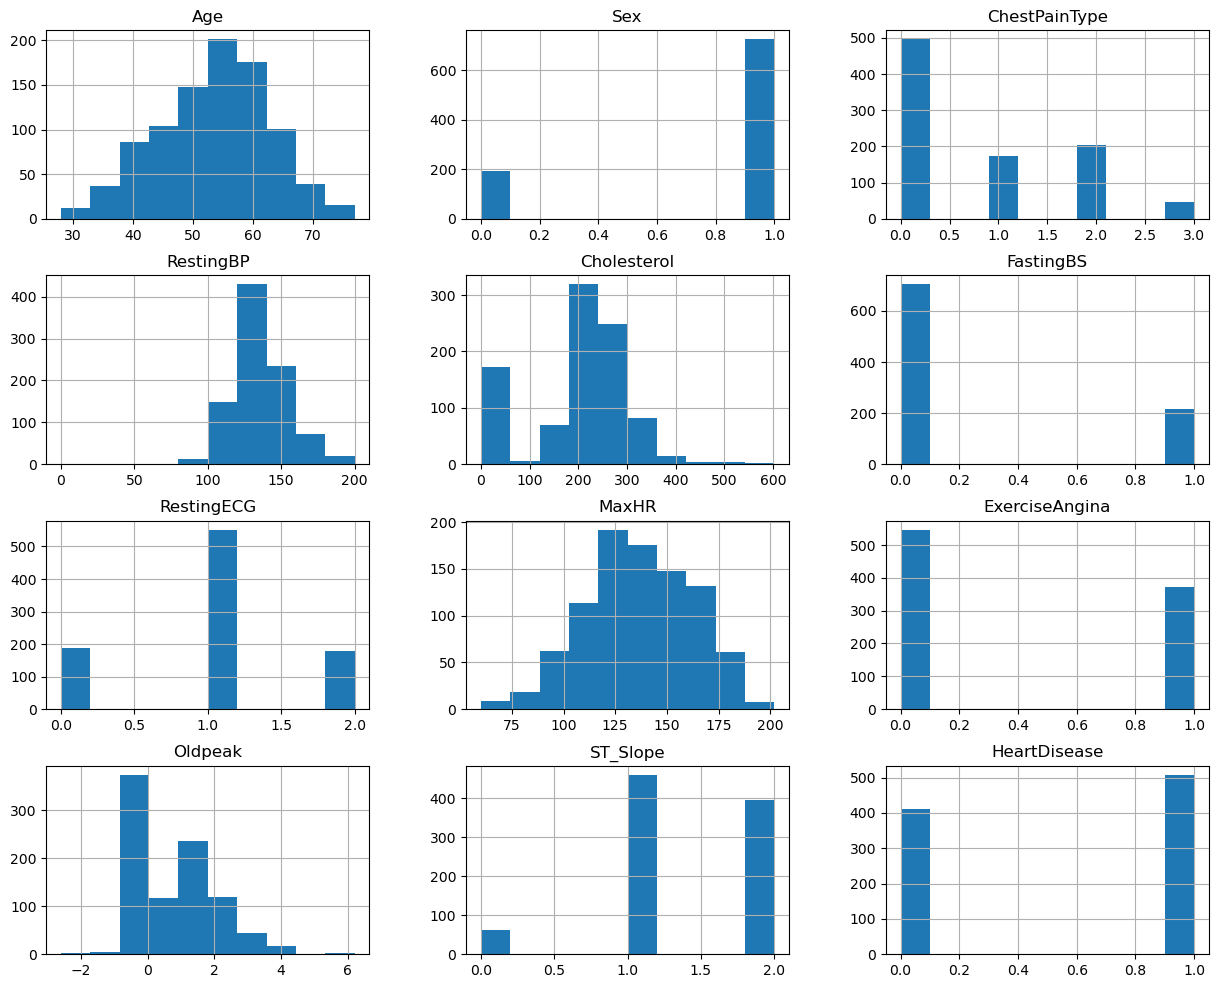

In [182]:
# Plot the distribution of the data after conversion to numeric
data.hist(figsize=(15,12));

### Binning of the numerical data and missing data imputation

##### Nulls in disguise: 
Some "Cholesterol" values are reported as 0, this is evidently a missing values that was filled with 0 <br>
since such value of cholesterol is not compatible with human life and in some situations, like medical emergencies, <br>
it's not possible or not useful to measure the level of cholesterol of a patient. <br>
We used the median of the non zero values to fill the missing cholesterol records. <br> <br>
Some "Oldpeak" values are reported as negative, althought the definition of Oldpeak is not always the same, such values <br>
are most likely missing values. <br>

We used 0 to fill the missing records of Oldpeak.

In [183]:
labels = [0, 1, 2]
num_rows = 3

# --- 1. Age ---
# Bins for <44, 45-60, >60 
# Motivation: it is a common division in medical literature
age_bins = [-float('inf'), 44, 60, float('inf')]

data['Age_Category'] = pd.cut(data['Age'], bins=age_bins, labels=labels, right=True)

# --- 2. RestingBP ---
# Bins for <120, 120-139, >=140
# Motivation: it's likely systolic pressure, the division is according to the American Heart Association
bp_bins = [-np.inf, 119, 139, np.inf] 

data['RestingBP_Category'] = pd.cut(data['RestingBP'], bins=bp_bins, labels=labels, right=True)

# --- 3. Cholesterol ---
# The 0 cholesterols are nulls in disguise: imputation with the median of the non 0 values 
chol_median = data.loc[data['Cholesterol'] > 0, 'Cholesterol'].median()
data.loc[data['Cholesterol'] == 0, 'Cholesterol'] = chol_median

# Bins for 0, 1-199, 200-239, >=240
# Motivation: desirable, borderline high, high, cholesterol levels according to the National Cholesterol Education Program
chol_bins = [1, 199, 239, np.inf]

data['Cholesterol_Category'] = pd.cut(data['Cholesterol'], bins=chol_bins, labels=labels, right=True)

# --- 4.  MaxHR ---
# In general the maximum heart rate is computed as 220-AGE so we compare that with the real heart rate
# Then we cut it in 3 bins: low, normal, high

data['MaxHR'] = df['MaxHR'] - (220 - df['Age'])
hr_bins = [-np.inf, -10, 10, np.inf] 
data['MaxHR_Category'] = pd.cut(data['MaxHR'], bins=hr_bins, labels=labels, right=True)

# --- 5. Oldpeak ---
# Bins for <1.0, 1.0-2.5, >2.5
# Motivation: Oldpeak is a value related to the ECG signal
# The negative Oldpeaks are nulls in disguise: imputation with 0
oldpeak_bins = [-np.inf, 0.99, 2.5, np.inf] 
data.loc[data['Oldpeak'] < 0, 'Oldpeak'] = 0

data['Oldpeak_Category'] = pd.cut(data['Oldpeak'], bins=oldpeak_bins, labels=labels, right=True)


data.drop(numerical_features, axis=1, inplace=True)

In [184]:
data.sample(5)

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease,Age_Category,RestingBP_Category,Cholesterol_Category,MaxHR_Category,Oldpeak_Category
46,1,0,0,1,0,2,0,0,1,1,0,0
812,0,2,0,1,0,1,0,1,0,1,1,1
179,0,0,0,1,0,2,0,1,1,1,0,0
375,0,2,0,2,0,2,1,2,2,1,0,0
590,1,1,0,2,0,2,0,2,1,0,0,0


In [185]:
data.describe()

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.789760,0.781046,0.233115,0.989107,0.404139,1.361656,0.553377
std,0.407701,0.956519,0.423046,0.631671,0.490992,0.607056,0.497414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.000000
max,1.000000,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000


### Target values distribution

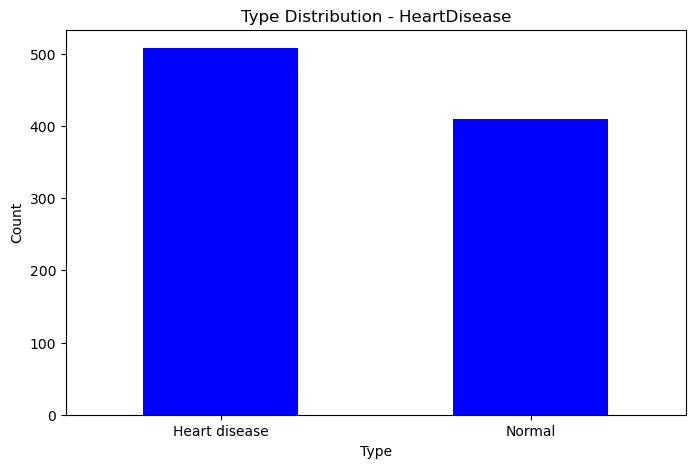

In [186]:
type_counts = data['HeartDisease'].value_counts()

mapped_counts = type_counts.rename(index={0: 'Normal', 1: 'Heart disease'})

# Create a bar plot for the type distribution
plt.figure(figsize=(8, 5))
mapped_counts.plot(kind='bar', color='blue')
plt.title('Type Distribution - HeartDisease')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Correlation between features and HeartDisease

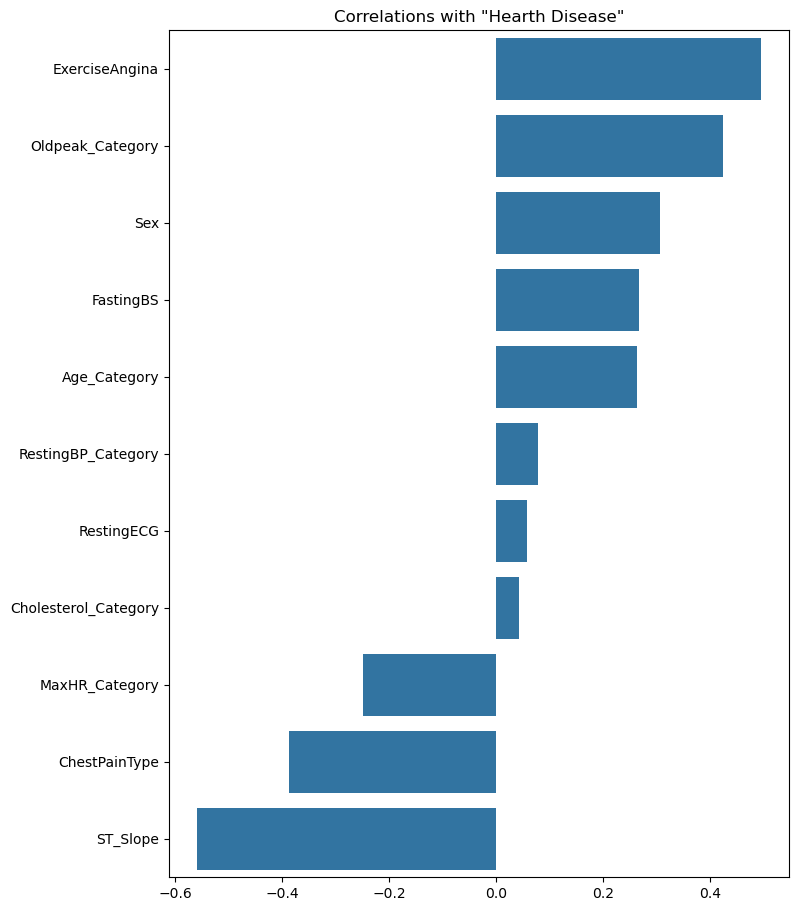

In [187]:
# Correlation of features with HeartDisease
hd_corr = data.corr()["HeartDisease"].sort_values(ascending=False)

limit = -1.0

indices = hd_corr.index
labels = []
corr = []
for i in range(1, len(indices)):
    if hd_corr[indices[i]]>limit:
        labels.append(indices[i])
        corr.append(hd_corr[i])


fig, ax = plt.subplots(figsize=(8,11))
sns.barplot(x=corr, y=labels, ax=ax)
plt.title('Correlations with "Hearth Disease"')
plt.show()


#### Train test split


In [188]:
target_variable = 'HeartDisease' 
X = data.drop(columns=[target_variable])
y = data[target_variable]

X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=random_state, train_size=0.80)

train_data = pd.concat([X_train, y_train], axis=1)

## Model Construction and visualization
- - - 

### "Custom" (Heart Shaped) Network

The graph is acyclic: True


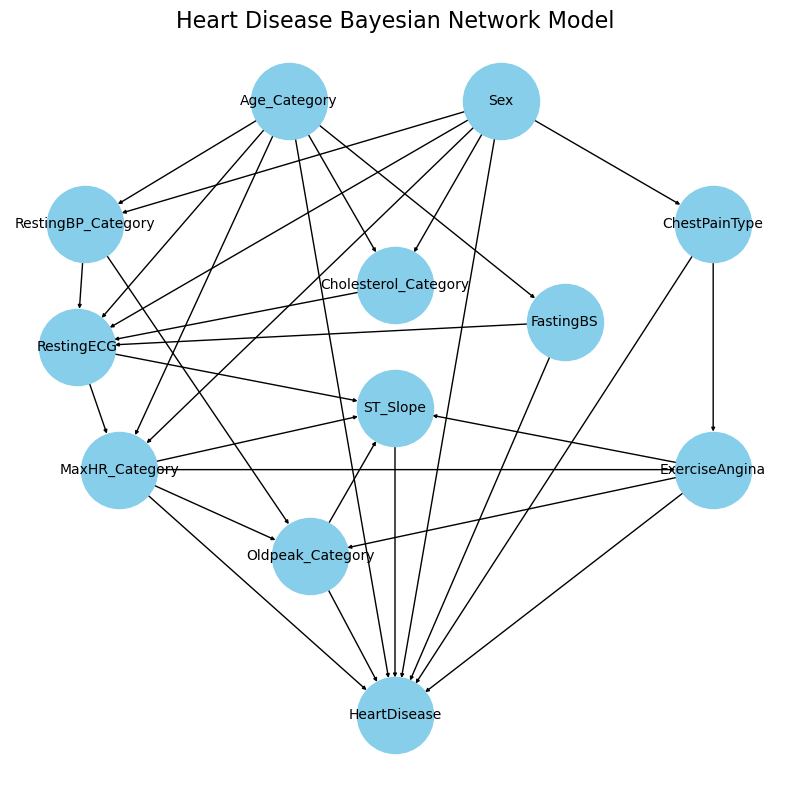

In [189]:
heart_disease_model = BayesianNetwork([
    ('Age_Category', 'RestingBP_Category'), ('Age_Category', 'Cholesterol_Category'), ('Age_Category', 'MaxHR_Category'),
    ('Age_Category', 'RestingECG'), ('Age_Category', 'FastingBS'), ('Age_Category', 'HeartDisease'), 
    ('Sex', 'Cholesterol_Category'),('Sex', 'MaxHR_Category'), ('Sex', 'RestingECG'),  ('Sex', 'RestingBP_Category'), ('Sex', 'ChestPainType'), ('Sex', 'HeartDisease'),
    ('FastingBS', 'RestingECG'), ('FastingBS', 'HeartDisease'),
    ('Cholesterol_Category', 'RestingECG'),
    ('RestingBP_Category', 'RestingECG'), ('RestingBP_Category', 'Oldpeak_Category'),
    ('RestingECG', 'ST_Slope'), ('RestingECG', 'MaxHR_Category'),
    ('MaxHR_Category', 'ST_Slope'), ('MaxHR_Category', 'ExerciseAngina'), ('MaxHR_Category', 'Oldpeak_Category'), ('MaxHR_Category', 'HeartDisease'), 
    ('ChestPainType', 'ExerciseAngina'), ('ChestPainType', 'HeartDisease'),
    ('ExerciseAngina', 'ST_Slope'), ('ExerciseAngina', 'Oldpeak_Category'), ('ExerciseAngina', 'HeartDisease'),
    ('Oldpeak_Category', 'ST_Slope'), ('Oldpeak_Category', 'HeartDisease'),
    ('ST_Slope', 'HeartDisease')
])

pos = {'Age_Category': [0.75, -0.5], 'Sex': [1.25, -0.5],
       'RestingBP_Category': [0.27, -1.], 'Cholesterol_Category': [1., -1.25], 'ChestPainType': [1.75,  -1],
       'FastingBS': [1.40, -1.40], 'RestingECG': [0.25, -1.5],
       'MaxHR_Category': [0.35,  -2],
       'ExerciseAngina': [1.75, -2], 'Oldpeak_Category': [0.80, -2.35], 'ST_Slope': [1.,  -1.75], 
       'HeartDisease': [1, -3]}

# We check the acyclicity of the graph
is_acyclic = nx.is_directed_acyclic_graph(heart_disease_model)
print(f"The graph is acyclic: {is_acyclic}")


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

nx.draw_networkx(heart_disease_model, pos=pos, ax=ax, node_size=3000,
                 node_color='skyblue', font_size=10, arrows=True, arrowsize=5)

ax.set_title('Heart Disease Bayesian Network Model', fontsize=16)
plt.axis('off')
fig.tight_layout()
plt.savefig(pathlib.Path.joinpath(project_dir, "out/custom_bn.png"))


### Search based Tree Network

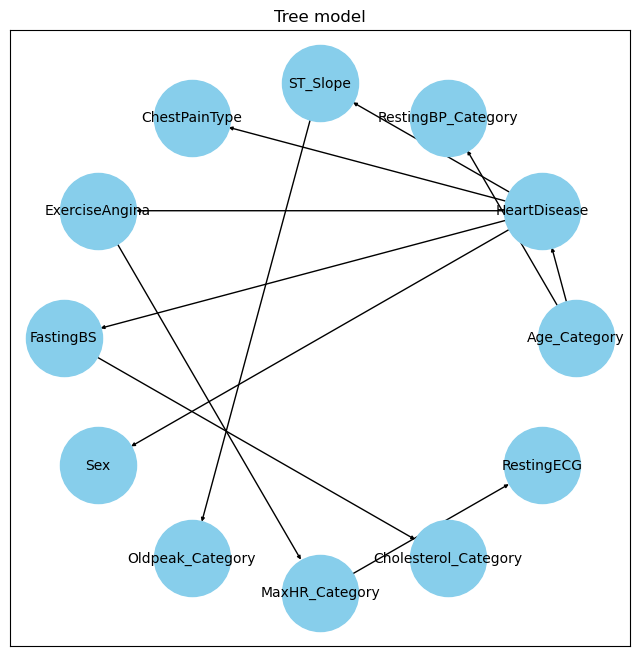

In [190]:
ts = TreeSearch(data=train_data, root_node='Age_Category')
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5,)

plt.savefig(pathlib.Path.joinpath(project_dir,"out/tree.png"))
ax.set_title('Tree model')
tree_model = BayesianNetwork(tree_model.edges())

### Search based HillClimb Network

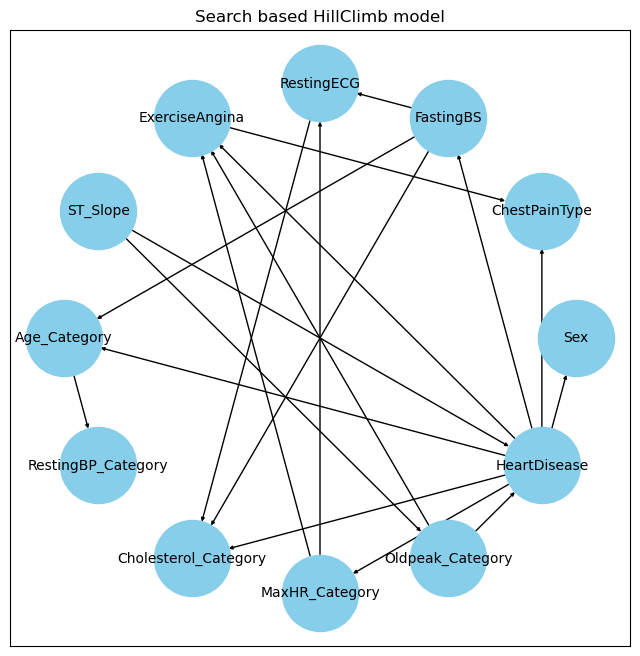

In [191]:
scoring_method = K2Score(data=train_data)
hc = HillClimbSearch(data=train_data) 
hc_model = hc.estimate(scoring_method=scoring_method,
                               max_indegree=4, max_iter=int(1e4), show_progress=False,)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_model, pos=nx.drawing.layout.circular_layout(hc_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5,)

plt.savefig(pathlib.Path.joinpath(project_dir, "out/hc_model.png"))

ax.set_title('Search based HillClimb model')
hc_model = BayesianNetwork(hc_model.edges())

### Constraint based Network

Since sex and age cannot be influenced by clinical or psychological conditions, they are set as root nodes. On the other hand, RestingECG, Cholesterol, and Resting Blood Pressure show the weakest correlation, so we remove their direct links to Hearth

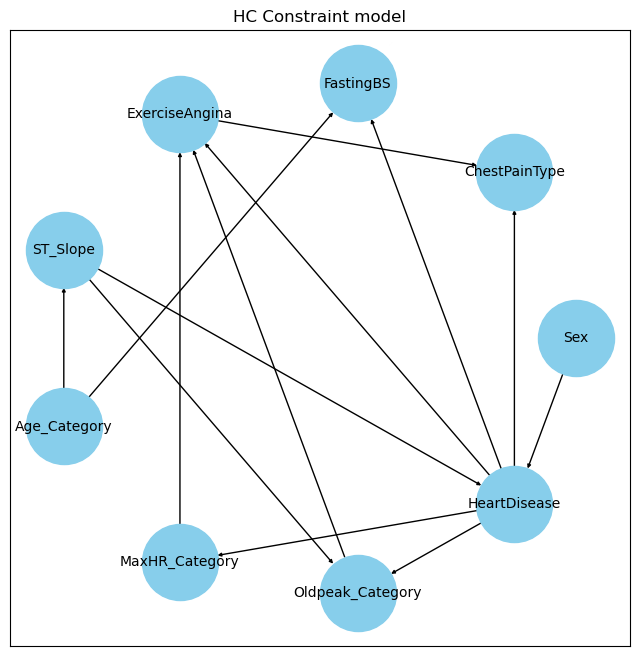

In [192]:
black_list = [(f, 'Sex') for f in data.columns] 
black_list += [(f, 'Age_Category') for f in data.columns]

trimmed_train_data = train_data.drop(columns=['Cholesterol_Category', 'RestingECG', 'RestingBP_Category'])
scoring_method = K2Score(data=trimmed_train_data)

hc = HillClimbSearch(data=trimmed_train_data)
hc_constraint_model = hc.estimate(scoring_method=scoring_method, black_list=black_list, max_iter=int(1e4), show_progress=False)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_constraint_model, pos=nx.drawing.layout.circular_layout(hc_constraint_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5)
plt.savefig(pathlib.Path.joinpath(project_dir,"out/hc_constraint_model.png"))

ax.set_title('HC Constraint model')
hc_constraint_model = BayesianNetwork(hc_constraint_model.edges())




### Computing CPDs for every model

In [193]:
models = [('custom', heart_disease_model), ('tree', tree_model), 
          ('hc', hc_model), ('hc constraint', hc_constraint_model)]

for name, model in models:
    print(f'Computing CPD for {name} model')   
    model.fit(train_data, estimator=MaximumLikelihoodEstimator)

Computing CPD for custom model
Computing CPD for tree model
Computing CPD for hc model
Computing CPD for hc constraint model


### Check the consistency of the models

In [194]:
for name, model in models:
    is_consistent = model.check_model()
    print(f"The model {name} is consistent: {is_consistent}")

The model custom is consistent: True
The model tree is consistent: True
The model hc is consistent: True
The model hc constraint is consistent: True


### Check independencies, Markov blankets

With pgmpy it is possible to analyse several different properties of the networks. For example, we can take a look at the different independencies which hold in the network, ask for the local semantics (any node in the network is independent of its non-descendents given its parents) for a set of nodes or ask for the Markov blanket of a certain node.

The Markov blanket of node HeartDisease is ['Oldpeak_Category', 'MaxHR_Category', 'FastingBS', 'ChestPainType', 'ExerciseAngina', 'Age_Category', 'Sex', 'ST_Slope']


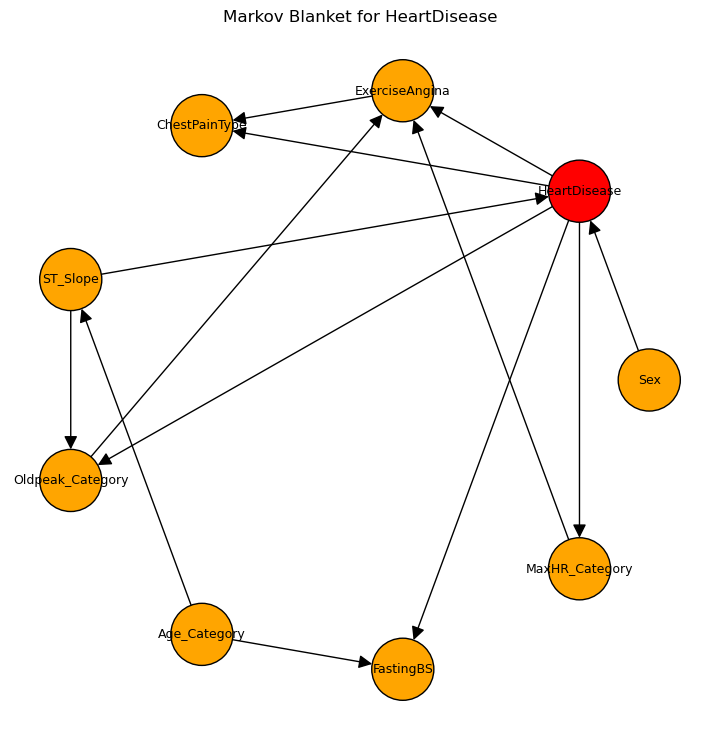

In [195]:
from utils import show_markov_blanket_nx

model_to_show = hc_constraint_model
node_to_show = 'HeartDisease'

print(f'The Markov blanket of node {node_to_show} is {model.get_markov_blanket(node_to_show)}')

blanket = model_to_show.get_markov_blanket(node_to_show)
fig = show_markov_blanket_nx(model_to_show,
                            project_dir=project_dir,
                            initial_node=node_to_show,
                            blanket=blanket)

In [196]:
nodes = ['Sex', 'Age_Category', 'FastingBS', 'MaxHR_Category', 'ST_Slope', 'HeartDisease']
print('Considering nodes:', nodes)

for name, model in models:
    print(f'Analyzing model: {name}')
    print(f'The total number of valid independence assertions is {len(model.get_independencies().get_assertions())}')
    print(f'Local semantics of the current model:\n{model.local_independencies(nodes)}')

    print()

Considering nodes: ['Sex', 'Age_Category', 'FastingBS', 'MaxHR_Category', 'ST_Slope', 'HeartDisease']
Analyzing model: custom
The total number of valid independence assertions is 2530
Local semantics of the current model:
(Sex ⟂ Age_Category, FastingBS)
(Age_Category ⟂ ChestPainType, Sex)
(FastingBS ⟂ ChestPainType, Sex, Cholesterol_Category, RestingBP_Category | Age_Category)
(MaxHR_Category ⟂ ChestPainType, FastingBS, Cholesterol_Category, RestingBP_Category | Age_Category, RestingECG, Sex)
(ST_Slope ⟂ Age_Category, FastingBS, Cholesterol_Category, RestingBP_Category, ChestPainType, Sex | MaxHR_Category, RestingECG, ExerciseAngina, Oldpeak_Category)
(HeartDisease ⟂ RestingECG, Cholesterol_Category, RestingBP_Category | Oldpeak_Category, MaxHR_Category, FastingBS, ChestPainType, ExerciseAngina, Age_Category, Sex, ST_Slope)

Analyzing model: tree
The total number of valid independence assertions is 21744
Local semantics of the current model:
(Sex ⟂ Oldpeak_Category, FastingBS, MaxHR_Ca

The Markov Blanket (MB) of **HeartDisease** is:<br>
**['Oldpeak_Category', 'MaxHR_Category', 'FastingBS', 'ChestPainType', 'ExerciseAngina', 'Age_Category', 'Sex', 'ST_Slope']**


**Observation:** According to this specific model, these 8 variables form the *minimal sufficient set* to predict **HeartDisease**. All other variables become irrelevant for predicting **HeartDisease** once the values of these 8 are known. This is a direct and powerful result for feature selection based on this model.

Any influence that **RestingECG**, **Cholesterol\_Category**, and **FastingBS** may have on **HeartDisease** is fully mediated by the variables included in the Markov Blanket. They do not provide any additional direct predictive information about **HeartDisease** if the MB is already known.



### Exact inference

In [197]:
inferences = [(name, VariableElimination(model)) for name, model in models]

#### Query 1: Heart Disease prediction on Age and Sex

$$P(\text{HeartDisease} | \text{Age\_Category} = 2, \text{Sex} = 1)$$


In [198]:
# Check the CPDs of the "Custom" model
evidence = {'Age_Category': 2, 'Sex': 1}

for name, inference in inferences:
    print(f'Inference for {name} model')
    print(inference.query(["HeartDisease"], evidence=evidence))
    print()

Inference for custom model
+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.3754 |
+-----------------+---------------------+
| HeartDisease(1) |              0.6246 |
+-----------------+---------------------+

Inference for tree model
+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.2136 |
+-----------------+---------------------+
| HeartDisease(1) |              0.7864 |
+-----------------+---------------------+

Inference for hc model
+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.2136 |
+-----------------+---------------------+
| HeartDisease(1) |              0.7864 |
+-----------------+---------------------+

Inference for hc constraint model
+-----

### Definition a model to investigate

In [209]:
inference = VariableElimination(tree_model)

Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc
Performing inference for model: hc constraint


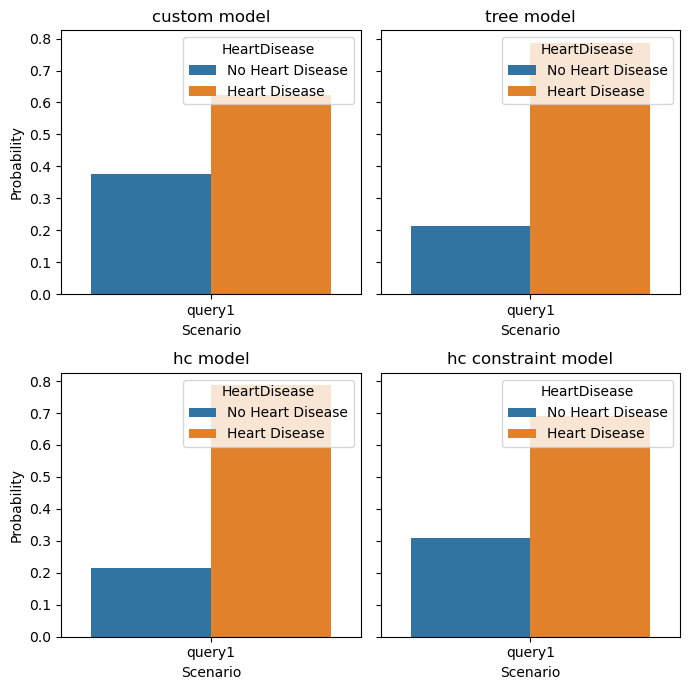

In [200]:
results_query1 = {}
for name, inference in inferences:
    results_query1[name] = {}
    print(f"Performing inference for model: {name}")
    results_query1[name]['query1'] = inference.query(["HeartDisease"], evidence, show_progress=False).values

plot_values(results_query1, label_map={0: 'No Heart Disease', 1: 'Heart Disease'})

### Query 2: Which stress factors cause a high risk of Heart disease in an male Adult patient?

$$P(\text{HeartDisease} | \text{Age\_Category} = 2, \text{Sex} = 1, \text{ST\_Slope} = 1)$$
$$P(\text{HeartDisease} | \text{Age\_Category} = 2, \text{Sex} = 1, \text{ExerciseAngina} = 1)$$
$$P(\text{HeartDisease} | \text{Age\_Category} = 2, \text{Sex} = 1, \text{Oldpeak} = 1)$$



In [201]:

print("CPD for ST_Slope")
print(inference.query(["HeartDisease"], evidence={'Age_Category': 2, 'Sex': 1, "ST_Slope": 1}))

print("\nCPD for ExerciseAngina")
print(inference.query(["HeartDisease"], evidence={'Age_Category': 2, 'Sex': 1, "ExerciseAngina": 1}))

print("\nCPD for Oldpeak_Category")
print(inference.query(["HeartDisease"], evidence={'Age_Category': 2, 'Sex': 1, "Oldpeak_Category": 1}))

CPD for ST_Slope
+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.1167 |
+-----------------+---------------------+
| HeartDisease(1) |              0.8833 |
+-----------------+---------------------+

CPD for ExerciseAngina
+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.1009 |
+-----------------+---------------------+
| HeartDisease(1) |              0.8991 |
+-----------------+---------------------+

CPD for Oldpeak_Category
+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.1719 |
+-----------------+---------------------+
| HeartDisease(1) |              0.8281 |
+-----------------+---------------------+


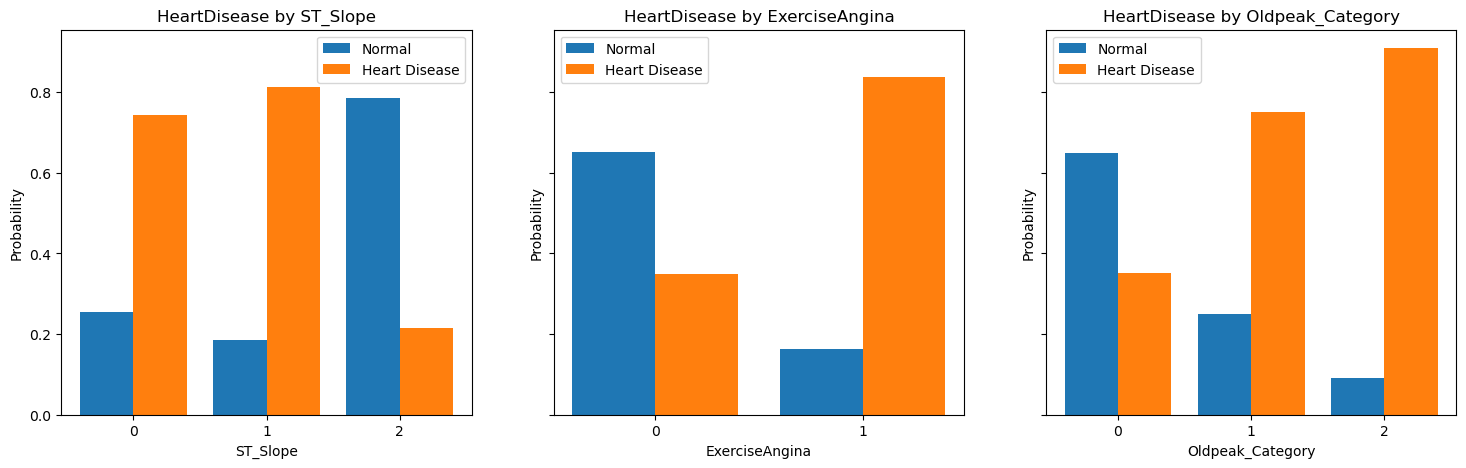

In [202]:
synthoms = {"ST_Slope": [0, 1, 2], "ExerciseAngina": [0, 1], "Oldpeak_Category": [0, 1, 2]}

results = []
answer_pain_types = {}

for synthom in synthoms:
    evidence = {} # Hightlight also results with {"Age_Category": 2, "Sex": 1}
    answer_pain_types[synthom] = {}
    for pain_type in synthoms[synthom]:
        evidence[synthom] = pain_type
        probs = inference.query(["HeartDisease"], evidence, show_progress=False).values

        results.append({
            'synthom': synthom,
            'pain_type': pain_type,
            'Normal': probs[0],
            'HeartDisease': probs[1]
        })

df = pd.DataFrame(results)


n_synthoms = df['synthom'].nunique()
fig, axes = plt.subplots(1, n_synthoms, figsize=(6 * n_synthoms, 5), sharey=True)

if n_synthoms == 1:
    axes = [axes]  
for ax, synthom in zip(axes, df['synthom'].unique()):
    temp = df[df['synthom'] == synthom]
    x = temp['pain_type']
    normal = temp['Normal']
    heart = temp['HeartDisease']

    ax.bar(x - 0.2, normal, width=0.4, label='Normal')
    ax.bar(x + 0.2, heart, width=0.4, label='Heart Disease')
    ax.set_xlabel(synthom)
    ax.set_xticks(x.unique())
    ax.set_ylabel('Probability')
    ax.set_title(f'HeartDisease by {synthom}')
    ax.legend()

Results show Flat and Downsloping ST segment patterns are most associated with Heart Disease, aligning with clinical findings.
- Flat slope: Indicates myocardial ischemia and increased cardiovascular risk.
- Downsloping slope: Strongly suggests more severe ischemia and carries a bad prognosis.
- Up: It is generally reassuring.

The presence of Angina during exercise is a strong indicator of potential underlying heart disease, specifically coronary artery disease.

Value of Oldpeak >= 1 are generally considered clinically significant for suggesting ischemia



#### Query 3: Heart Disease risk by age and chest pain type comparison among models

$$P(\text{HeartDisease} | \text{ChestPainType} = C) \text{ with } C \in \{0, 1, 2, 3\}$$

In [203]:
chest_type = {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}

print(inference.query(["HeartDisease"], evidence={'ChestPainType': chest_type['ASY']}))

+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.2273 |
+-----------------+---------------------+
| HeartDisease(1) |              0.7727 |
+-----------------+---------------------+


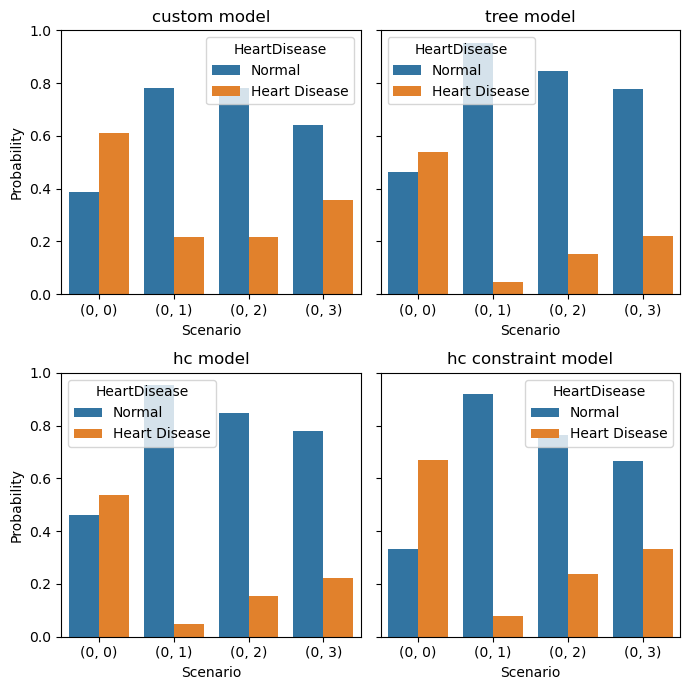

In [204]:
# Age: 0 -> <44, 1 -> 45-60, 2 -> >60 

age = 0

values = [(age, chest_type['ASY']), (age, chest_type['ATA']), (age, chest_type['NAP']), (age, chest_type['TA'])]

answer_values = {}
for name, inference in inferences:
    answer_values[name] = {}
    for age, chest_pain_type in values:
        evidence = {"Age_Category": age, "ChestPainType": chest_pain_type}
        answer_values[name][(age, chest_pain_type)] = inference.query(["HeartDisease"], evidence, show_progress=False).values
plot_values(answer_values, label_map={0: 'Normal', 1: 'Heart Disease'})

In the previous queries we observed that the probability of having a HeartDisease condition is much higher for "Old" patient.
Here we are looking at young patient so the probability of "Normal" is much higher.

Results confirms ASY (Asymptomatic) and TA (Typical Angina) are most linked to Heart Disease in this data.

TA is the classic symptom; 
ASY reflects the known danger of silent/late-diagnosed disease (high risk despite no typical pain).

The probability is now in favor of Asymptomatic and Typical Angina. So we can deduce that this two factors has some influence in heart disease. <br>
Let's see the full spectrum now:

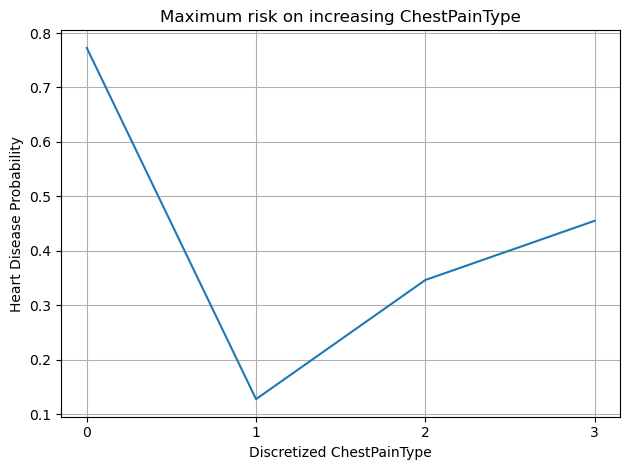

In [205]:
from pgmpy.factors.discrete import State

illness = "ChestPainType"

heart_disease = []
predictions_list = []
for t in range(data[illness].max() + 1):
    evidence = [State(illness, t)]
    prob = inference.query(["HeartDisease"], evidence=dict(evidence), show_progress=False)
    heart_disease.append(prob.values[-1])

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(len(heart_disease)), heart_disease)
plt.title(f"Maximum risk on increasing {illness}")
plt.xlabel(f"Discretized {illness}")
plt.ylabel("Heart Disease Probability")
plt.grid()
plt.xticks(data[illness].unique())
plt.tight_layout()
plt.savefig(pathlib.Path.joinpath(project_dir,"out/hd_spectrum.png"))
plt.show()

### Let's see our model outcomes

In [228]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

all_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
       'ST_Slope', 'Age_Category', 'RestingBP_Category',
       'Cholesterol_Category', 'MaxHR_Category', 'Oldpeak_Category']

most_correlated_features = ['ExerciseAngina', 'Oldpeak_Category', 'ST_Slope', 'ChestPainType', 'Sex']


X_test_evidence = X_test[most_correlated_features]

for name, model in models:
    if name == 'hc constraint':
        X_test_trimmed = X_test_evidence.drop(columns=['Cholesterol_Category', 'RestingECG', 'RestingBP_Category'], errors='ignore')
        predictions_df = model.predict(X_test_trimmed)
    else:
        predictions_df = model.predict(X_test_evidence)
    
    print(f"Evaluating model: {name}")
    y_pred = predictions_df[target_variable]
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on the test set: {accuracy:.4f}")
    
    print("Predicted: ", y_pred[:10].values)
    print("True: ", y_test[:10].values)
    report = metrics.classification_report(y_test, y_pred)
    print("- " * 40)

  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating model: custom
Accuracy on the test set: 0.8478
Predicted:  [0 1 1 1 1 1 0 0 0 0]
True:  [0 1 1 1 1 1 0 0 0 0]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating model: tree
Accuracy on the test set: 0.8533
Predicted:  [0 1 1 1 1 1 0 0 0 1]
True:  [0 1 1 1 1 1 0 0 0 0]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating model: hc
Accuracy on the test set: 0.8750
Predicted:  [1 1 1 1 1 1 0 0 0 1]
True:  [0 1 1 1 1 1 0 0 0 0]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating model: hc constraint
Accuracy on the test set: 0.8696
Predicted:  [0 1 1 1 1 1 0 0 0 1]
True:  [0 1 1 1 1 1 0 0 0 0]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


### Performance test

In [229]:
iter = 10000
evidence = {'Age_Category': 0, 'Sex': 1, 'ExerciseAngina': 0}

for name, inference in inferences:
    start_time = time.time()
    for i in range(iter):
        inference.query(["HeartDisease"], evidence, show_progress=False).values
    end_time = time.time()
    elapsed_time = (end_time - start_time) / iter
    print(f"Elapsed time for {name}: ", elapsed_time, "seconds")

Elapsed time for custom:  0.0005418007850646972 seconds
Elapsed time for tree:  0.00012171211242675781 seconds
Elapsed time for hc:  0.00035794591903686525 seconds
Elapsed time for hc constraint:  0.00024531338214874265 seconds
